In [1]:
from lib.functions0 import *
from lib.utility import *
import numpy as np
from scipy.linalg import expm
from qiskit.utils.mitigation.fitters import CompleteMeasFitter
from qiskit.ignis.mitigation.measurement import  complete_meas_cal
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
import matplotlib.pyplot as plt
#%load_ext autoreload
#%autoreload 2
import warnings
warnings.filterwarnings('ignore')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community',
                            group='ibmquantumawards', 
                            project='open-science-22')

backend_sim_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_real_jakarta = provider.get_backend('ibmq_jakarta')
backend_sim = Aer.get_backend('qasm_simulator')

In [2]:
import qiskit
qiskit.utils.mitigation.fitters.__file__

'/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/utils/mitigation/fitters.py'

In [40]:
n_steps=100
time=np.pi*3/4
#initial_state={"110": 1}
shots = 32000
backend = backend_sim_jakarta

X = np.array([[0,1],[1,0]])  #defining the pauli matrices
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
H = np.array([[1/np.sqrt(2),1/np.sqrt(2)],[1/np.sqrt(2),-1/np.sqrt(2)]])
Id = np.eye(2)

# defining the hamiltonian divided in: 
#       - H1: first two qubits interactions.
#       - H2: second two qubits interactions.

H1 = np.kron(X, np.kron(X,Id)) + np.kron(Y, np.kron(Y,Id)) + np.kron(Z, np.kron(Z,Id)) 
H2 = np.kron(Id, np.kron(X,X)) + np.kron(Id, np.kron(Y,Y)) + np.kron(Id, np.kron(Z,Z)) 

Had3=np.kron(H, np.kron(H,H))

# building numerically the trotter step matrix, and the whole operator (trotter step)^n_steps.

trotter_step_matrix_= expm(-time/n_steps*H1*1j).dot(expm(-time/n_steps*H2*1j))
trotterized = np.linalg.matrix_power(trotter_step_matrix_, n_steps)
Matrix(trotterized).n(3, chop=True)
#Matrix(Had3)

Matrix([
[1.0*I,                0,                0,                0,                0,                0,                0,     0],
[    0,  0.333 + 0.334*I,  0.333 + 0.309*I,                0, -0.666 + 0.356*I,                0,                0,     0],
[    0,  0.333 + 0.356*I, -0.666 + 0.334*I,                0,  0.333 + 0.309*I,                0,                0,     0],
[    0,                0,                0,  0.333 + 0.334*I,                0,  0.333 + 0.356*I, -0.666 + 0.309*I,     0],
[    0, -0.666 + 0.309*I,  0.333 + 0.356*I,                0,  0.333 + 0.334*I,                0,                0,     0],
[    0,                0,                0,  0.333 + 0.309*I,                0, -0.666 + 0.334*I,  0.333 + 0.356*I,     0],
[    0,                0,                0, -0.666 + 0.356*I,                0,  0.333 + 0.309*I,  0.333 + 0.334*I,     0],
[    0,                0,                0,                0,                0,                0,                0, 1.0*I]]

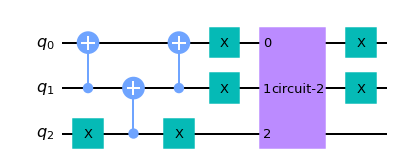

In [41]:
qr=QuantumRegister(3, name="q")
B_qc=QuantumCircuit(qr, name="B")
B_qc.x(qr[2])
B_qc.cx(qr[1],qr[0])
B_qc.cx(qr[2],qr[1])
B_qc.cx(qr[1],qr[0])
B_qc.x([qr[0],qr[1],qr[2]])
B_qc.append(Toffoli_gate,[qr[0],qr[1],qr[2]])
B_qc.x([qr[0],qr[1]])

B_qc.draw(output="mpl")

In [42]:
B=matrix_from_circuit(B_qc)
B

Matrix([
[  0,   0,   0,   0, 1.0,   0,   0,   0],
[  0,   0, 1.0,   0,   0,   0,   0,   0],
[  0, 1.0,   0,   0,   0,   0,   0,   0],
[1.0,   0,   0,   0,   0,   0,   0,   0],
[  0,   0,   0, 1.0,   0,   0,   0,   0],
[  0,   0,   0,   0,   0, 1.0,   0,   0],
[  0,   0,   0,   0,   0,   0, 1.0,   0],
[  0,   0,   0,   0,   0,   0,   0, 1.0]])

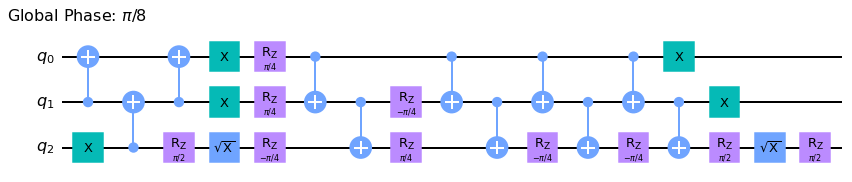

In [43]:
transpile(B_qc, basis_gates=["cx", "x", "rz", "sx"]).draw(output="mpl")

In [44]:
#for _ in range(n_steps): # here is computed the evolution operator numerically, with n_steps trotter steps.
#
#    numeric_evolution_matrix=(numeric_evolution_matrix*trotter_step_matrix_(2*time/n_steps)).evalf(precision)


M_N = B*trotterized*B.H
M_N = Matrix([M_N[0:4],M_N[8:12],M_N[16:20],M_N[24:28]])
M_N.evalf(5)

Matrix([
[ 0.33306 + 0.33421*I,  0.33306 + 0.35646*I, -0.66611 + 0.30934*I,                  0],
[ 0.33306 + 0.30934*I, -0.66611 + 0.33421*I,  0.33306 + 0.35646*I,                  0],
[-0.66611 + 0.35646*I,  0.33306 + 0.30934*I,  0.33306 + 0.33421*I,                  0],
[                   0,                    0,                    0, 1.0603e-15 + 1.0*I]])

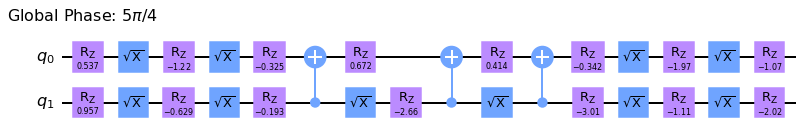

In [45]:
qc=QuantumCircuit(2, name="$M^N$")
qc.unitary(M_N,[0,1])    
M_N_qc=transpile(qc,basis_gates=['cx','x','sx','rz']) 

M_N_qc.draw(output="mpl")

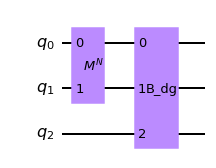

In [46]:
initial_state="000"

qr_U = QuantumRegister(3, name="q")
qc_U = QuantumCircuit(qr_U, name="evo")

### preparing the initial state

l=0
for k in [2,1,0]:
    if initial_state[l]=='1':
        qc_U.x(qr_U[k])
    l+=1

### appending the evolution

qc_U.append(M_N_qc,[qr_U[0],qr_U[1]])
qc_U.append(B_qc.inverse(),[qr_U[0],qr_U[1],qr_U[2]])

qc_U.draw(output="mpl")

In [47]:
U_ideal=matrix_from_circuit(qc_U, type="numpy")
Matrix(U_ideal)

Matrix([
[                            0,                             0,                             0, 1.0*I,                             0,                             0,                             0,     0],
[-0.666110803 + 0.3564569882*I, 0.3330554015 + 0.3093375062*I, 0.3330554015 + 0.3342055056*I,     0,                             0,                             0,                             0,     0],
[0.3330554015 + 0.3093375062*I, -0.666110803 + 0.3342055056*I, 0.3330554015 + 0.3564569882*I,     0,                             0,                             0,                             0,     0],
[                            0,                             0,                             0,     0, 0.3330554015 + 0.3342055056*I, 0.3330554015 + 0.3564569882*I, -0.666110803 + 0.3093375062*I,     0],
[0.3330554015 + 0.3342055056*I, 0.3330554015 + 0.3564569882*I, -0.666110803 + 0.3093375062*I,     0,                             0,                             0,                     

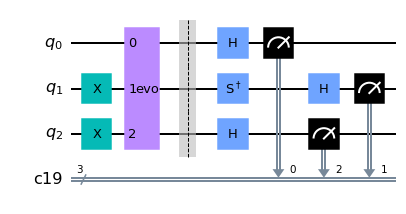

In [48]:
qr_evo = QuantumRegister(3, name="q")
qc_evo = QuantumCircuit(qr_evo, name="U")

qc_evo.x([qr_evo[1],qr_evo[2]])
qc_evo.append(qc_U, qr_evo)

qcs_tomo = state_tomography_circuits(qc_evo, qr_evo)
qcs_tomo[3].draw(output="mpl")

In [49]:
qr_cal = QuantumRegister(3)
cal_circ, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr_cal, circlabel='mcal')

In [50]:
cal_circ[0].draw()

░ ┌─┐      
q1796_0: ─░─┤M├──────
          ░ └╥┘┌─┐   
q1796_1: ─░──╫─┤M├───
          ░  ║ └╥┘┌─┐
q1796_2: ─░──╫──╫─┤M├
          ░  ║  ║ └╥┘
  c20: 3/════╩══╩══╩═
             0  1  2

In [51]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

In [52]:
calib_circuits_identity = []
calib_circuits_itself = []

for i in state_labels:

    cr_cal_itself = ClassicalRegister(3)
    qr_cal_itself = QuantumRegister(3)
    qc_cal_itself = QuantumCircuit(qr_cal_itself, cr_cal_itself, name=f"mcalcal_{i}")

    cr_cal_id = ClassicalRegister(3)
    qr_cal_id = QuantumRegister(3)
    qc_cal_id = QuantumCircuit(qr_cal_id, cr_cal_id, name=f"mcalcal_{i}")

    qc_cal_id.x(qr_cal_id)
    qc_cal_id.append(qc_U, qr_cal_id)

    for k in range(3):
        if i[::-1][k] == "1":
            qc_cal_itself.x(qr_cal_itself[k])
        else:
            qc_cal_id.x(qr_cal_id[k])
        
    qc_cal_itself.append(qc_U, qr_cal_itself)
    
    qc_cal_id.measure(qr_cal_id, cr_cal_id)
    qc_cal_itself.measure(qr_cal_itself, cr_cal_itself)

    calib_circuits_identity.append(qc_cal_id)
    calib_circuits_itself.append(qc_cal_itself)

In [53]:
calib_circuits_identity[1].draw()

┌───┐┌──────┐     ┌─┐      
q1800_0: ┤ X ├┤0     ├─────┤M├──────
         ├───┤│      │┌───┐└╥┘┌─┐   
q1800_1: ┤ X ├┤1 evo ├┤ X ├─╫─┤M├───
         ├───┤│      │├───┤ ║ └╥┘┌─┐
q1800_2: ┤ X ├┤2     ├┤ X ├─╫──╫─┤M├
         └───┘└──────┘└───┘ ║  ║ └╥┘
  c24: 3/═══════════════════╩══╩══╩═
                            0  1  2

In [54]:
calib_circuits_itself[1].draw()

┌───┐┌──────┐┌─┐      
q1799_0: ┤ X ├┤0     ├┤M├──────
         └───┘│      │└╥┘┌─┐   
q1799_1: ─────┤1 evo ├─╫─┤M├───
              │      │ ║ └╥┘┌─┐
q1799_2: ─────┤2     ├─╫──╫─┤M├
              └──────┘ ║  ║ └╥┘
  c23: 3/══════════════╩══╩══╩═
                       0  1  2

In [55]:
job_tomo=execute(qcs_tomo, backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_identity=execute(calib_circuits_identity, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_itself=execute(calib_circuits_itself, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_qiskit=execute(cal_circ, backend, shots=shots, initial_layout=[1,3,5])

In [56]:
meas_fitter_our_identity = CompleteMeasFitter(job_cal_our_identity.result(), state_labels=state_labels)
meas_fitter_our_itself = CompleteMeasFitter(job_cal_our_itself.result(), state_labels=state_labels)
meas_fitter_qiskit = CompleteMeasFitter(job_cal_qiskit.result(), state_labels=state_labels)

In [57]:
Matrix(meas_fitter_qiskit.cal_matrix)

Matrix([
[0.94259375,      0.048,   0.034625,  0.0016875,   0.030625,    0.00175,  0.0010625,   3.125e-5],
[0.01684375,  0.9129375,  0.0005625, 0.03278125,     0.0005,  0.0316875,          0, 0.00096875],
[0.01134375, 0.00084375,  0.9170625,  0.0494375, 0.00046875,   9.375e-5, 0.03015625, 0.00153125],
[0.00028125, 0.00990625,   0.018125,  0.8878125,          0,  0.0003125,     0.0005, 0.02971875],
[     0.028,  0.0013125, 0.00103125,   0.000125,   0.939375, 0.04946875,  0.0348125,     0.0015],
[    0.0005,  0.0266875,          0, 0.00084375, 0.01809375, 0.90590625,  0.0004375, 0.03228125],
[ 0.0004375,          0, 0.02803125,     0.0015, 0.01084375,     0.0005,     0.9145,   0.048625],
[         0,  0.0003125,  0.0005625,  0.0258125,   9.375e-5, 0.01028125, 0.01853125, 0.88534375]])

In [58]:
Matrix(meas_fitter_our_identity.cal_matrix)

Matrix([
[ 0.8873125,    0.06125,    0.04625, 0.00896875, 0.03753125, 0.00371875,  0.0023125, 0.01003125],
[   0.03275, 0.85940625, 0.00784375, 0.04484375,    0.00225, 0.03765625, 0.00984375, 0.00196875],
[ 0.0256875, 0.00784375,   0.870875, 0.06071875,   0.001625, 0.01128125, 0.03590625,   0.002875],
[0.00696875, 0.02409375,  0.0301875,     0.8385,       0.01, 0.00140625, 0.00190625,  0.0358125],
[0.03515625, 0.00328125,   0.002125, 0.00878125,   0.886125, 0.06059375,  0.0461875,  0.0096875],
[ 0.0021875,  0.0330625,  0.0095625, 0.00209375, 0.03240625,   0.852375, 0.00784375,   0.045625],
[0.00128125, 0.00971875, 0.03115625,  0.0031875,  0.0239375, 0.00865625,   0.864625, 0.06096875],
[0.00865625, 0.00134375,      0.002, 0.03290625,   0.006125,  0.0243125,   0.031375, 0.83303125]])

In [59]:
U_tilde_identity=meas_fitter_our_identity.cal_matrix
U_tilde_itself=meas_fitter_our_itself.cal_matrix
U_tilde_qiskit=meas_fitter_qiskit.cal_matrix

In [60]:
def matrix_from_cirquit(qc, phase=0, type="sympy"):

    backend = Aer.get_backend('unitary_simulator')
    job = execute(qc, backend, shots=32000)
    result = job.result()
    A=result.get_unitary(qc, decimals=10)*np.exp(1j*phase)
    if type=="sympy":
        return Matrix(A)
    else:
        return A

In [61]:
qr_basi = QuantumRegister(3)
qc_basi = QuantumCircuit(qr_basi)

qcs_basis = state_tomography_circuits(qc_basi, qr_basi)

qcs_basis[0].remove_final_measurements()

qcs_basis[16].draw()

░ ┌─────┐ ┌───┐      ┌─┐   
q3100_0: ─░─┤ Sdg ├─┤ H ├──────┤M├───
          ░ └─┬─┬─┘ └───┘      └╥┘   
q3100_1: ─░───┤M├───────────────╫────
          ░   └╥┘  ┌─────┐┌───┐ ║ ┌─┐
q3100_2: ─░────╫───┤ Sdg ├┤ H ├─╫─┤M├
          ░    ║   └─────┘└───┘ ║ └╥┘
  c37: 3/══════╩════════════════╩══╩═
               1                0  2

In [62]:
meas_fitter_qiskit.cal_matrix

array([[9.4259375e-01, 4.8000000e-02, 3.4625000e-02, 1.6875000e-03,
        3.0625000e-02, 1.7500000e-03, 1.0625000e-03, 3.1250000e-05],
       [1.6843750e-02, 9.1293750e-01, 5.6250000e-04, 3.2781250e-02,
        5.0000000e-04, 3.1687500e-02, 0.0000000e+00, 9.6875000e-04],
       [1.1343750e-02, 8.4375000e-04, 9.1706250e-01, 4.9437500e-02,
        4.6875000e-04, 9.3750000e-05, 3.0156250e-02, 1.5312500e-03],
       [2.8125000e-04, 9.9062500e-03, 1.8125000e-02, 8.8781250e-01,
        0.0000000e+00, 3.1250000e-04, 5.0000000e-04, 2.9718750e-02],
       [2.8000000e-02, 1.3125000e-03, 1.0312500e-03, 1.2500000e-04,
        9.3937500e-01, 4.9468750e-02, 3.4812500e-02, 1.5000000e-03],
       [5.0000000e-04, 2.6687500e-02, 0.0000000e+00, 8.4375000e-04,
        1.8093750e-02, 9.0590625e-01, 4.3750000e-04, 3.2281250e-02],
       [4.3750000e-04, 0.0000000e+00, 2.8031250e-02, 1.5000000e-03,
        1.0843750e-02, 5.0000000e-04, 9.1450000e-01, 4.8625000e-02],
       [0.0000000e+00, 3.1250000e-04, 5.6

In [63]:
C_matrices_itself = []
C_matrices_identity = []

U_ideal_inv = np.linalg.inv(U_ideal)
U_ideal_inv_abs = np.abs(U_ideal_inv)**2

#C_itself = np.matmul(U_tilde_itself, )
C_identity = U_tilde_identity

for base in qcs_basis:
    
    base.remove_final_measurements()

    base_matrix = matrix_from_cirquit(base, type="numpy")
    base_matrix_H = np.linalg.inv(base_matrix)

    C_aus_itself = np.linalg.multi_dot([base_matrix, U_tilde_itself, U_ideal_inv,  base_matrix_H])
    #C_aus_itself = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), U_tilde_itself, U_ideal_inv,  base_matrix_H])
    #C_aus_itself = np.linalg.multi_dot([base_matrix, U_tilde_qiskit, np.linalg.inv(U_tilde_qiskit), C_itself])
    C_aus_identity = np.matmul(base_matrix, np.matmul(C_identity, base_matrix_H))

    C_matrices_identity.append(np.asarray(C_aus_identity))
    C_matrices_itself.append(np.asarray(C_aus_itself))

In [64]:
from copy import deepcopy

meas_fitters_identity = []
meas_fitters_itself = []

for C_new in C_matrices_identity:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_identity)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_identity.append(meas_fitter_our_aus)

for C_new in C_matrices_itself:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_itself)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_itself.append(meas_fitter_our_aus)

In [65]:
target_state = (One^One^Zero).to_matrix()
#target_state = (Zero^One^One).to_matrix()


fids=np.zeros(4)

raw_res=deepcopy(job_tomo.result())
qiskit_res=deepcopy(raw_res)
identity_res=deepcopy(raw_res)
itself_res=deepcopy(raw_res)

In [66]:
raw_res.get_counts(-1)

{'010': 1132,
 '000': 194,
 '110': 6642,
 '001': 971,
 '100': 851,
 '011': 14489,
 '111': 1119,
 '101': 6602}

In [67]:
for i in range(27):

    old_counts=raw_res.get_counts(i)
    new_counts_qiskit = meas_fitter_qiskit.filter.apply(old_counts, method="least_squares")
    qiskit_res.results[i].data.counts = new_counts_qiskit

    new_counts_id = meas_fitters_identity[i].filter.apply(old_counts, method="least_squares")
    identity_res.results[i].data.counts = new_counts_id

    new_counts_it = meas_fitters_itself[i].filter.apply(old_counts, method="least_squares")
    itself_res.results[i].data.counts = new_counts_it

In [68]:
qiskit_res.get_counts(-1)

{'000': 131.26124577677524,
 '001': 224.24060276085203,
 '010': 115.9538608494871,
 '011': 16289.827216402035,
 '100': 250.68394564706009,
 '101': 7237.651137675255,
 '110': 7196.255724424848,
 '111': 554.1262664636848}

In [69]:
It_comp=occurrences_to_vector(itself_res.get_counts(-1))/(shots)
It_H=np.dot(Had3,It_comp)
Matrix(It_H)

Matrix([
[0.353553390593274],
[0.353553390593274],
[0.353553390593274],
[0.353553390593274],
[0.353553390593274],
[0.353553390593274],
[0.353553390593274],
[0.353553390593274]])

In [70]:
itself_res.get_counts(0)

{'000': 32000.0}

In [71]:
itself_res.get_counts(-1)

{'000': 32000.0}

In [72]:
identity_res.get_counts(-1)

{'000': 1.491171141490782e-10,
 '001': 8.522884481741281e-09,
 '010': 1.518497600326362e-08,
 '011': 17077.68189146302,
 '100': 4.881820260796403e-09,
 '101': 7479.580425036929,
 '110': 7391.589379871423,
 '111': 51.14830360014417}

In [73]:
fids[0] = fidelity_count(raw_res, qcs_tomo, target_state)
fids[1] = fidelity_count(qiskit_res, qcs_tomo, target_state)
fids[2] = fidelity_count(identity_res, qcs_tomo, target_state)
fids[3] = fidelity_count(itself_res, qcs_tomo, target_state)

fids

array([0.20434632, 0.22126378, 0.21903341, 0.03035908])

In [74]:
occurrences_to_vector(identity_res.get_counts(-1))

array([1.49117114e-10, 8.52288448e-09, 1.51849760e-08, 1.70776819e+04,
       4.88182026e-09, 7.47958043e+03, 7.39158938e+03, 5.11483036e+01])

# Confronto caso ideale

In [38]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Returns the matrix representation of the XXX Heisenberg model for 3 spin-1/2 particles in a line
def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H

# Returns the matrix representation of U_heis3(t) for a given time t assuming an XXX Heisenberg Hamiltonian for 3 spins-1/2 particles in a line
def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

In [39]:
initial_state = One^One^Zero

#((initial_state @ U_heis3(float(time)) @ initial_state).eval())**2
np.abs((~initial_state @ U_heis3(float(time)) @ initial_state).eval())**2

0.11111111111111122